# Project: Explore Braun dataset


__Upstream Steps__

* Assemble adata
* Filtered to select cortex, cerebellum, thalamus
* Sub-sampled to 75000 cells


__This notebook__

* QC filter on cells
* Expression filter on genes
* Normalization and log10 transformation by Scanpy functions
* Feature selection (HVG) by Scanpy functions
* Dimensionality reduction
* Batch correction by Harmony



# Dataset Information

## References

* [Paper Reference: Comprehensive cell atlas of the first-trimester developing human brain](https://www.science.org/doi/10.1126/science.adf1226)
* [Data and code repository: GitHub Repo](https://github.com/linnarsson-lab/developing-human-brain)


> Short description: 26 brain specimens spanning 5 to 14 postconceptional weeks (pcw) were dissected into 111 distinct biological samples. Each sample was subjected to single-cell RNA sequencing, resulting in 1,665,937 high-quality single-cell


__Subsample of the dataset selecting cortex, cerebellum and thalamus__

<div class="alert alert-block alert-info"><b>Cell populations identified by the authors:</b> 

* __Erythrocyte__
* __Fibroblast__
* __Glioblast__
* __Immune__
* __Neural crest__
* __Neuroblast__
* __Neuron__
* __Neuronal IPC__
* __Oligo__
* __Placodes__
* __Radial glia__
* __Vascular__

-----

# 1. Environment

## 1.1 Modules

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import igraph as ig
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix

#Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#utils
from datetime import datetime

In [2]:
# Custom functions
sys.path.append('../HelperFunctions')
import Day1Helper as fn

## 1.2 Settings


In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## 1.3 Input file

You can set parameters useful for your analysis in the cells below and then recall them during the analysis

In [4]:
#path = '../DataDir/InputData/'
Id = 'Project_AssembledAdata.h5ad'
input_file = path + Id

## 1.4 Other parameters

You can set parameters useful for your analysis in the cells below and then recall them during the analysis

In [5]:
#Cell filtering  
MIN_GENES = 1000
MAX_GENES = 8000

MIN_COUNTS = 1500
MAX_COUNTS = 15000

PCT_MITO = 10
PCT_RIBO = 30

#Gene Filtering
PCT_CELLS = 1

----

# 2. Data Load


## 2.1 Read adata file

In [6]:
adata = sc.read_h5ad(input_file)
adata.var_names_make_unique()

## 2.2 Explore metadata

### ⚠️❓ *Which are the main / most interesting metadata associated with barcodes (.obs)? How can you plot/inspect them?* 

<details>

<summary>Hint</summary>

> adata.obs.columns # to check information stored in .obs
> 
> adata.obs['myCol'].value_counts().plot.bar() #Specifying the column of interest
>
> adata.obs['myCol'].value_counts().plot.bar()
>
> pd.crosstab(adata.obs['myCol1'], adata.obs['myCol2'])

</details>

In [7]:
adata.obs.columns

Index(['Og_Subregion', 'Og_Tissue', 'Og_TopLevelCluster_x', 'Og_dissection',
       'Og_Donor', 'Og_Age', 'Og_Week', 'Og_Chemistry', 'run_id', 'sample_id',
       'cell_label', 'brain_region', 'cell_class'],
      dtype='object')

<Axes: xlabel='brain_region'>

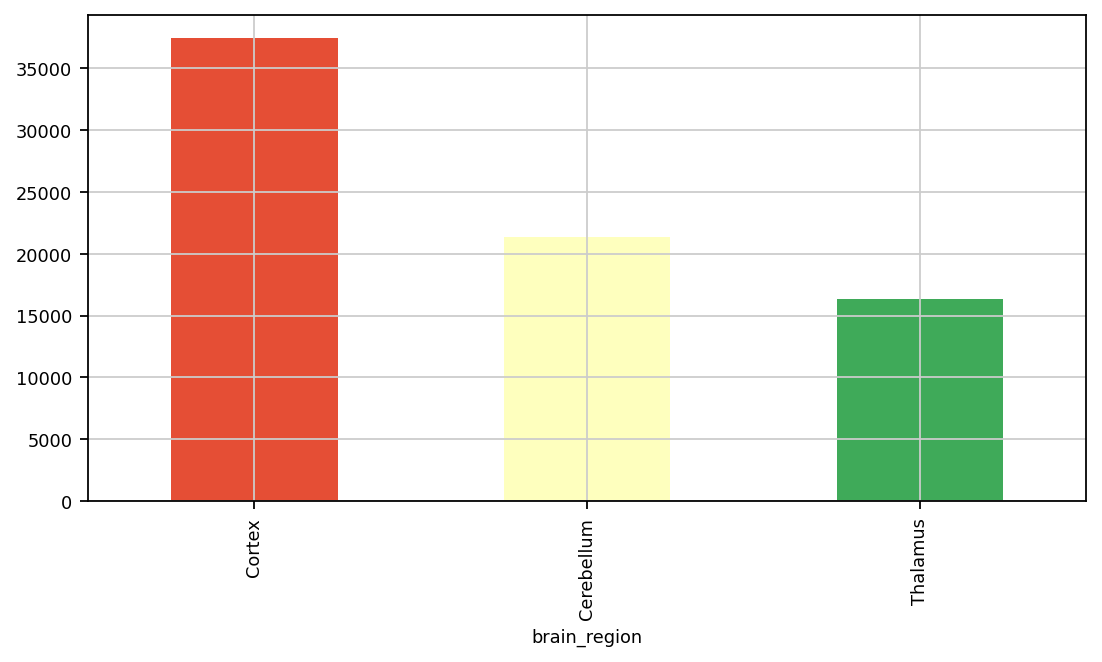

In [8]:
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['brain_region'].value_counts())))

adata.obs['brain_region'].value_counts().plot.bar(color=category_colors)

In [9]:
pd.crosstab(adata.obs['Og_Donor'], adata.obs['Og_Chemistry'])

Og_Chemistry    v2    v3
Og_Donor                
BRC2006       4309     0
BRC2021       2058     0
BRC2057       2706     0
BRC2061          0  8474
BRC2073       2736     0
BRC2110       1622     0
BRC2114       3313     0
BRC2147       2096     0
BRC2191          0  7400
XDD:334       1387     0
XDD:342          0  3446
XDD:351          0  4423
XDD:358          0  8752
XDD:359          0  3180
XDD:385          0  5775
XHU:292       2292     0
XHU:297       7623     0
XHU:307       3408     0

<Axes: xlabel='cell_label'>

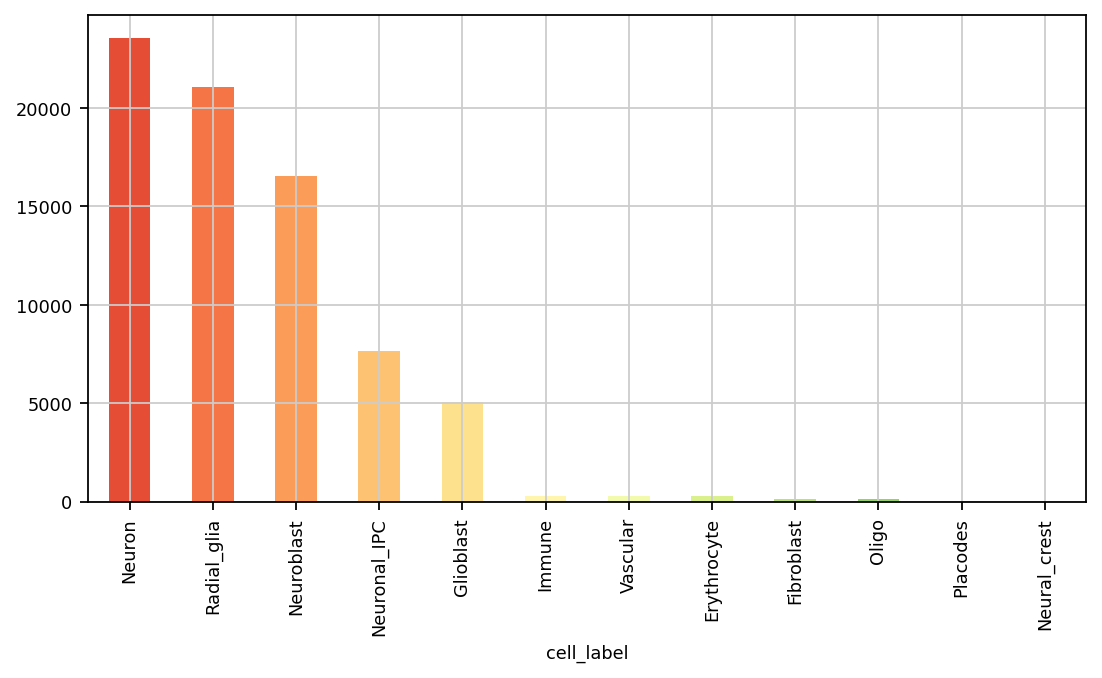

In [10]:
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['cell_label'].value_counts())))

adata.obs['cell_label'].value_counts().plot.bar(color=category_colors)

In [11]:
pd.crosstab(adata.obs['cell_label'], adata.obs['cell_class'])

cell_class    Erythrocyte_Cerebellum_Pre  Erythrocyte_Cortex_Pre  \
cell_label                                                         
Erythrocyte                           79                     138   
Fibroblast                             0                       0   
Glioblast                              0                       0   
Immune                                 0                       0   
Neural_crest                           0                       0   
Neuroblast                             0                       0   
Neuron                                 0                       0   
Neuronal_IPC                           0                       0   
Oligo                                  0                       0   
Placodes                               0                       0   
Radial_glia                            0                       0   
Vascular                               0                       0   

cell_class    Erythrocyte_Thalamus_Pre  Fibroblast_Cerebellum_Pre  \
cell_label                                                          
Erythrocyte                         48                          0   
Fibroblast                           0                         49   
Glioblast                            0                          0   
Immune                               0                          0   
Neural_crest                         0                          0   
Neuroblast                           0                          0   
Neuron                               0                          0   
Neuronal_IPC                         0                          0   
Oligo                                0                          0   
Placodes                             0                          0   
Radial_glia                          0                          0   
Vascular                             0                          0   

cell_class    Fibroblast_Cortex_Pre  Glioblast_Cerebellum_Pre  \
cell_label                                                      
Erythrocyte                       0                         0   
Fibroblast                       81                         0   
Glioblast                         0                      1306   
Immune                            0                         0   
Neural_crest                      0                         0   
Neuroblast                        0                         0   
Neuron                            0                         0   
Neuronal_IPC                      0                         0   
Oligo                             0                         0   
Placodes                          0                         0   
Radial_glia                       0                         0   
Vascular                          0                         0   

cell_class    Glioblast_Cortex_Pre  Glioblast_Thalamus_Pre  \
cell_label                                                   
Erythrocyte                      0                       0   
Fibroblast                       0                       0   
Glioblast                     3297                     456   
Immune                           0                       0   
Neural_crest                     0                       0   
Neuroblast                       0                       0   
Neuron                           0                       0   
Neuronal_IPC                     0                       0   
Oligo                            0                       0   
Placodes                         0                       0   
Radial_glia                      0                       0   
Vascular                         0                       0   

cell_class    Immune_Cerebellum_Pre  Immune_Cortex_Pre  ...  \
cell_label                                              ...   
Erythrocyte                       0                  0  ...   
Fibroblast                        0                  0  ...   
Glioblast                         0             

## 2.3 Calculate QCs

In [12]:
#Find mito and ribo genes
mito_genes = adata.var_names.str.startswith('MT-')   
ribo_genes = adata.var_names.str.contains('^RPS|^RPL')

#qc_vars wants a column of adataata.var containing T/F or 1/0 indicating the genes to be selected for sub-statistics
adata.var['mito'] = adata.var_names.str.startswith('MT-')    
adata.var['ribo']= adata.var_names.str.contains('^RPS|^RPL')

#Compute metrics (inplace=True to append to adata)
sc.pp.calculate_qc_metrics(adata, log1p=True, qc_vars=['mito','ribo'], inplace=True, percent_top=None)

In [13]:
adata

AnnData object with n_obs × n_vars = 75000 × 33538
    obs: 'Og_Subregion', 'Og_Tissue', 'Og_TopLevelCluster_x', 'Og_dissection', 'Og_Donor', 'Og_Age', 'Og_Week', 'Og_Chemistry', 'run_id', 'sample_id', 'cell_label', 'brain_region', 'cell_class', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'Chromosome', 'End', 'Start', 'Strand', 'EnsembleCode', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_condition', 'schema_version', 'title'

----

# 3. Discard low quality barcodes and lowly expressed genes

### 3.1 ⚠️❓ *Which parameters would you evaluate to discard low-quality barcodes?*

<details>

<summary>Hint</summary>

__You can evaluate the following metrics related to quality as preliminary step for filtering:__ 

* __Mitochondrial gene counts:__ high proportions are indicative of poor-quality cells, related to loss of cytoplasmic RNA from perforated cells: mitochondrial transcripts are protected by mitochondrial membrane and therefore less likely to escape through tears in the cell membrane. 
* __Ribosomal Protein gene counts:__ high proportion are indicative of a shallow sequencing, because very highly expressed genes occupy most of the reads
* __Number of genes:__ related to sequencing depth/quality
* __Number of UMI counts for each gene:__ gene-wise sum of UMI counts (in all the cells) 


</details>

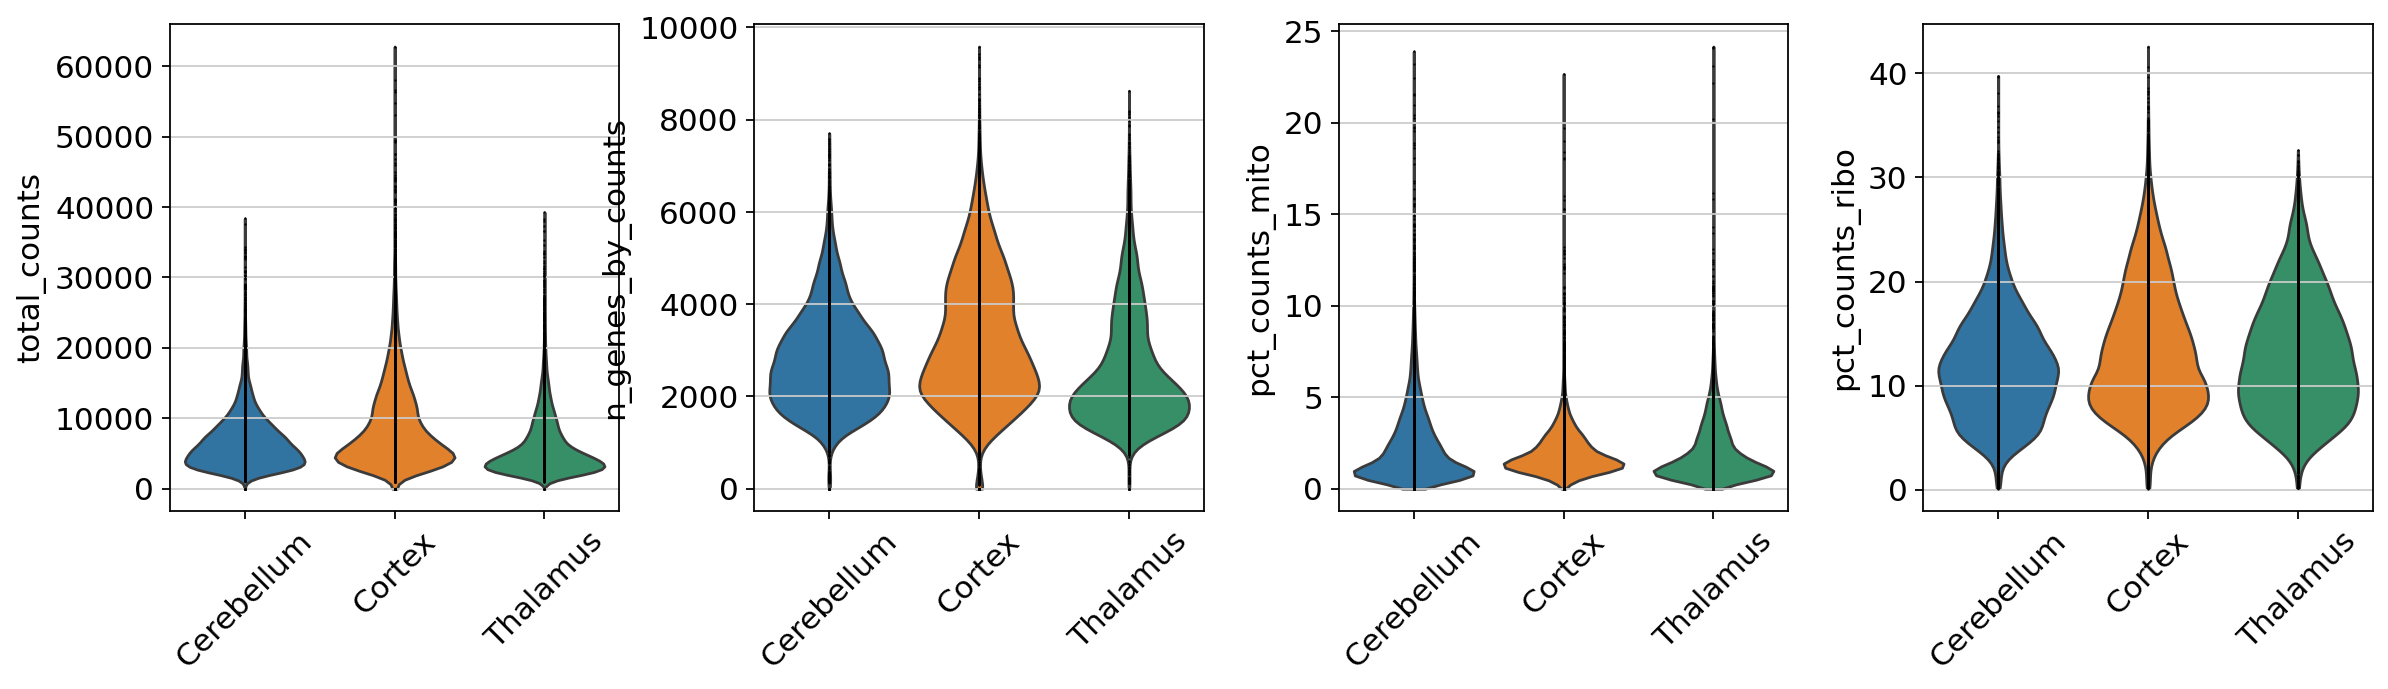

In [14]:
# write your code 
sc.settings.set_figure_params(dpi=80)
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'], groupby='brain_region',
             jitter=False, multi_panel=True, rotation=45)

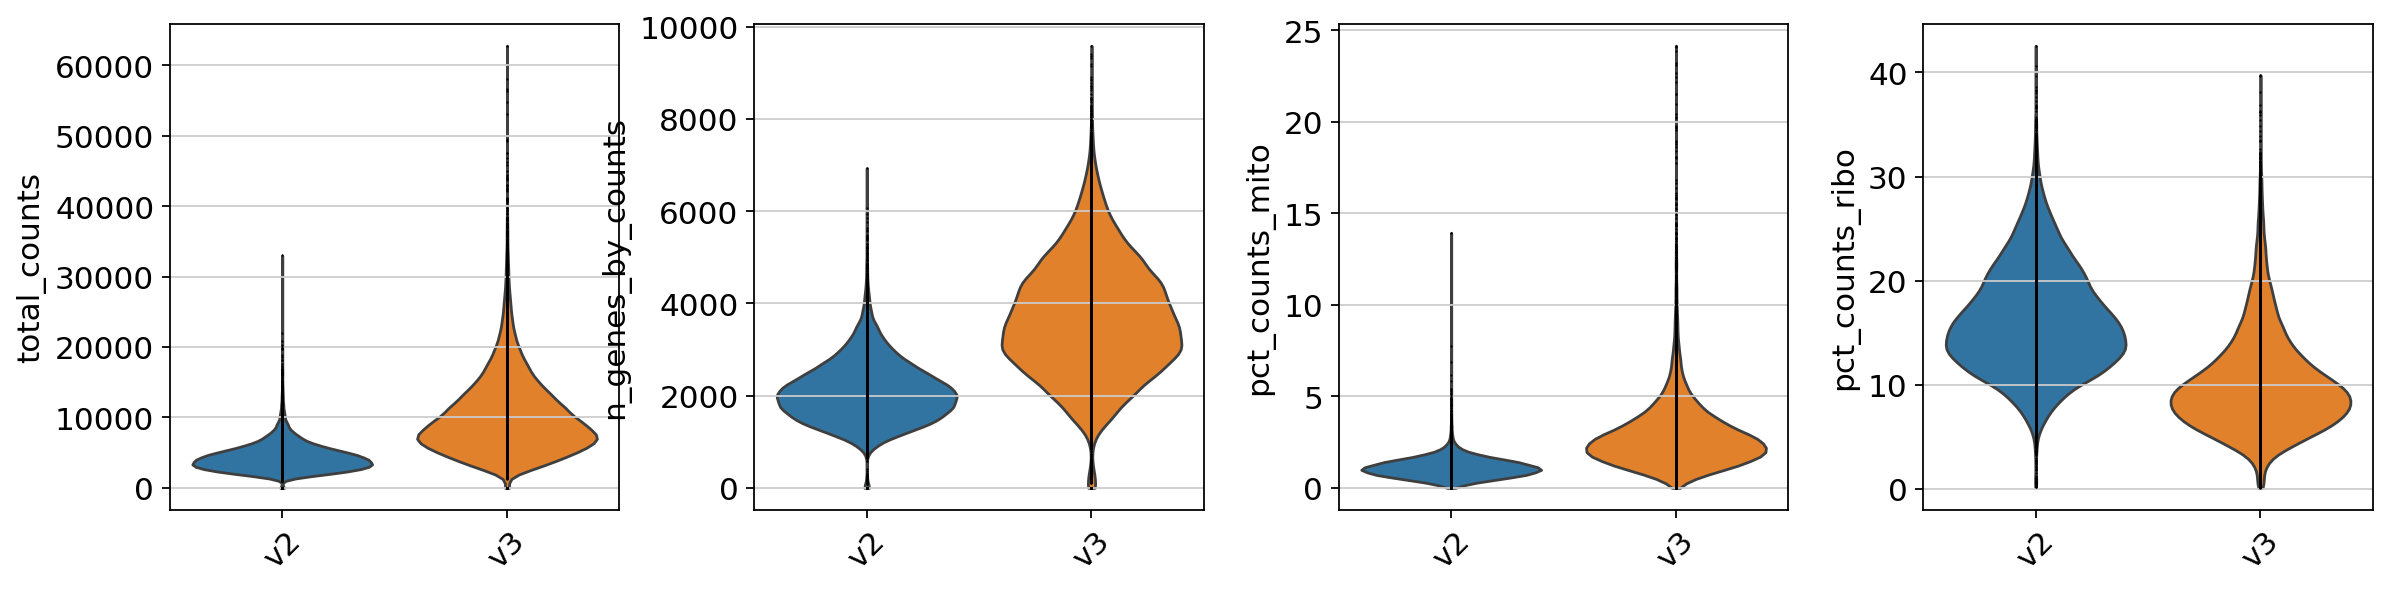

In [15]:
# write your code 
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'], groupby='Og_Chemistry',
             jitter=False, multi_panel=True, rotation=45)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


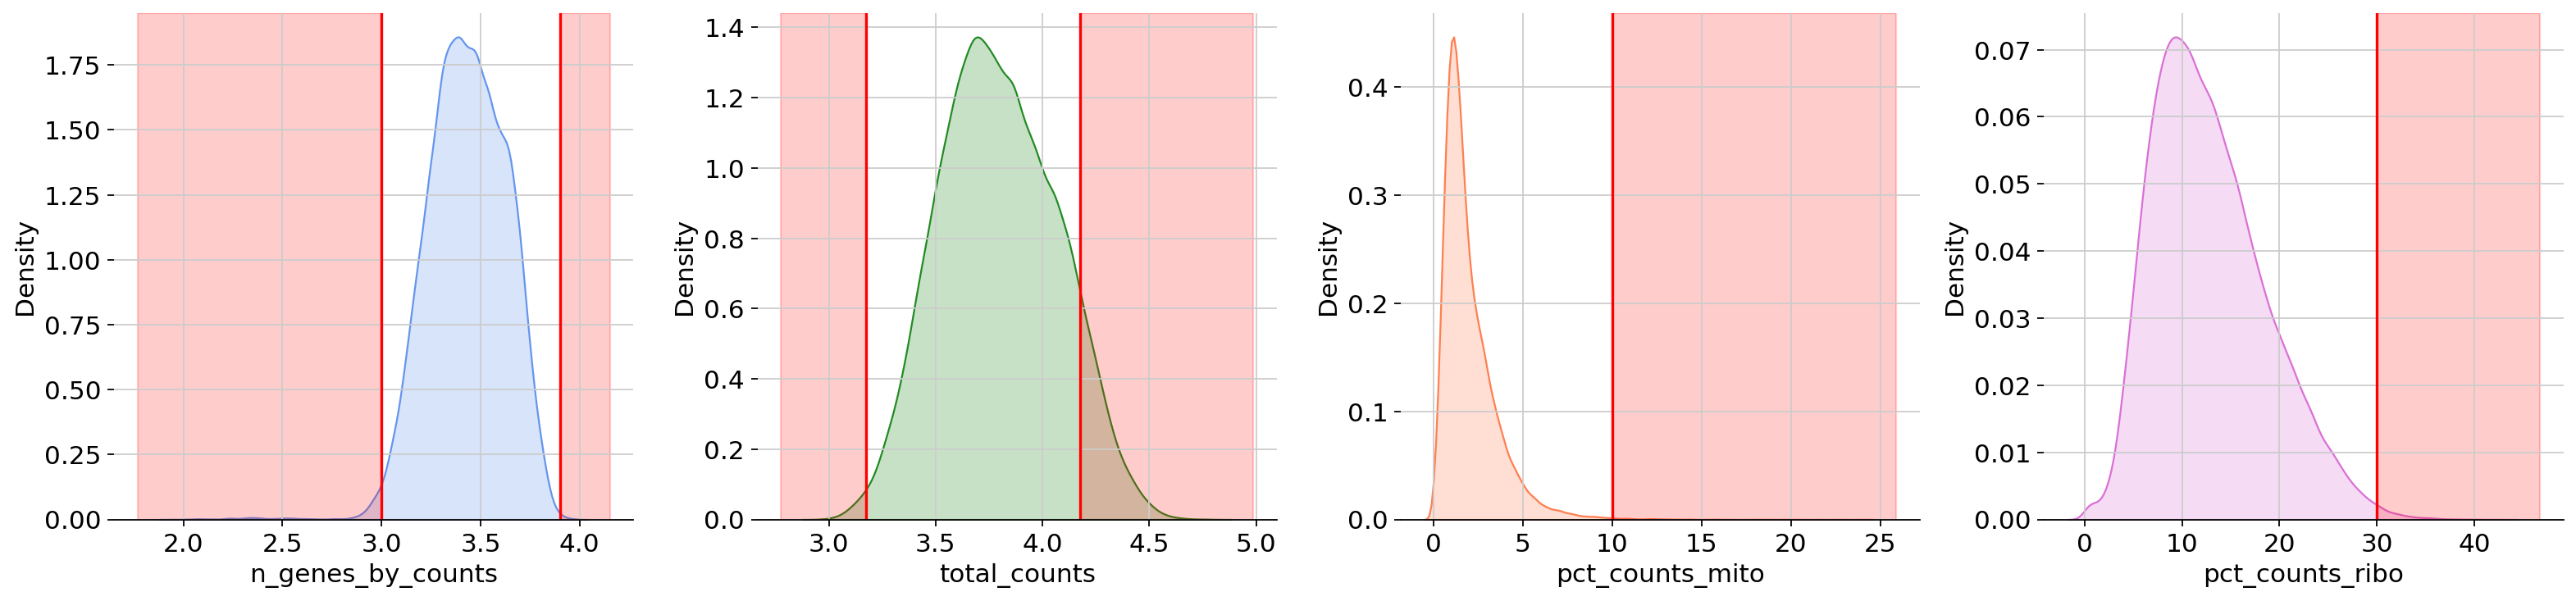

In [16]:
fn.densityQCs(adataObj = adata, hue = None, 
              min_counts = MIN_COUNTS, max_counts = MAX_COUNTS, 
              min_genes = MIN_GENES, max_genes = MAX_GENES, 
              pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

### 3.2 ⚠️❓ *How would you describe overall the quality of this dataset?*

Overall the quality of the data is good, resulting in a low number of barcodes discarded according to the thresholds. There is some heterogeneity in the quality according to brain region and especially according to the assay version (Og_chemistry).

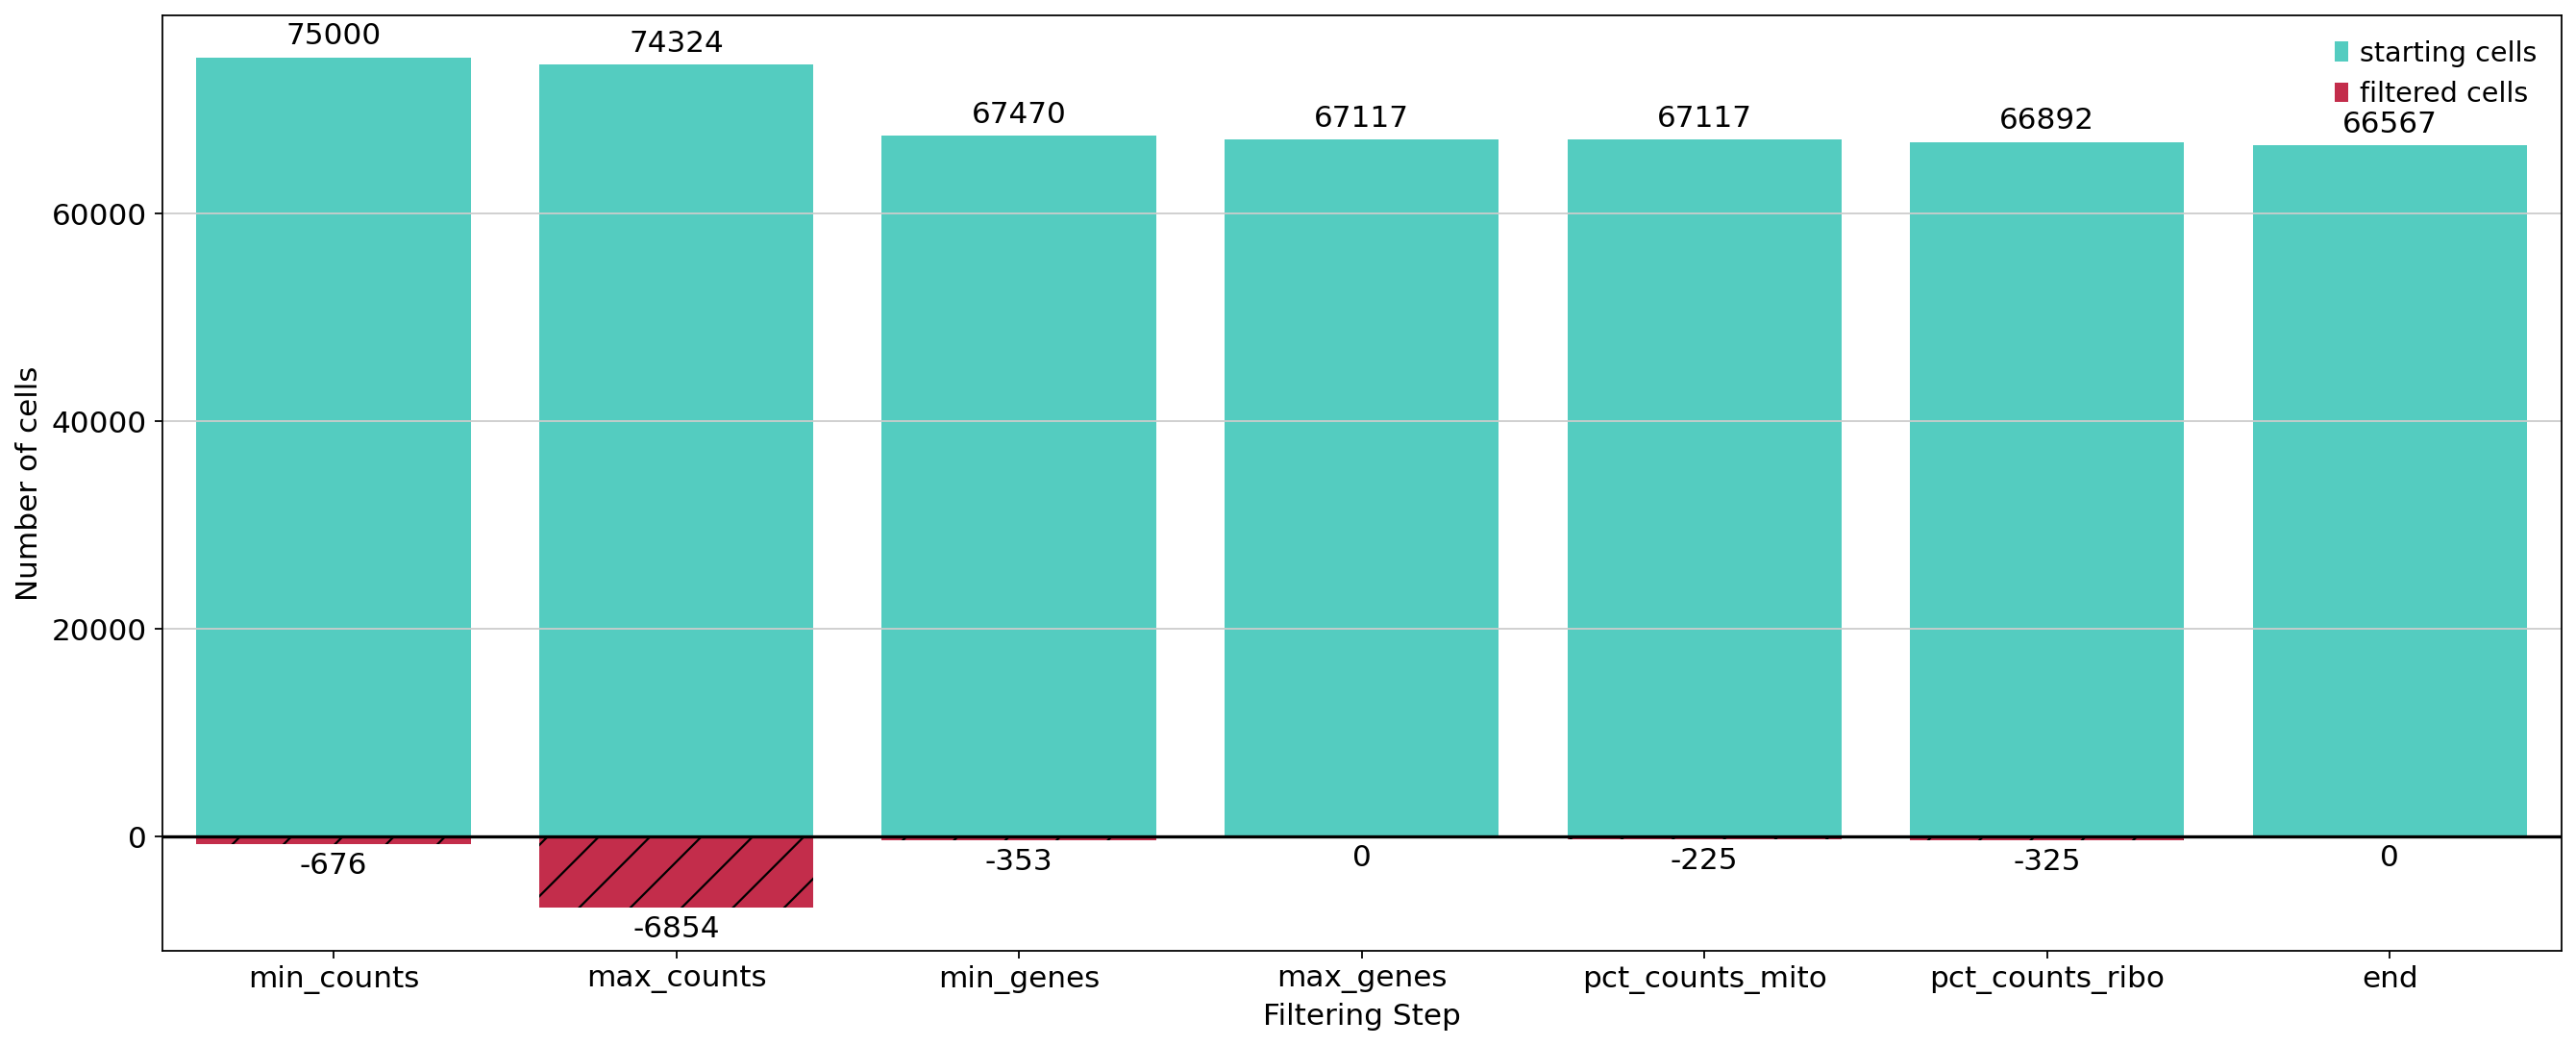

In [17]:
fn.filterCellBarplot(adataObj = adata,
                     min_counts = MIN_COUNTS, max_counts = MAX_COUNTS,
                     min_genes = MIN_GENES, max_genes = MAX_GENES,
                     pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

<details>

<summary>Hint</summary>

__You can using diagnostic plots to check the distribution of QC, such as violin plots or density plots__ 

> sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'], groupby='Meta_Col',
             jitter=False, multi_panel=True, rotation=45) # specifying the column of interest

</details>



### 3.3 ⚠️❓ *Which thresholds would you set for the filtering of low-quality barcodes?*
__Once you have set the thresholds, proceed with the barcode filtering steps__

<details>

<summary>Hint</summary>

__Apply sc.pp.filter_cells function for cell filtering and sc.pp.filter_genes for gene filtering__ 

> sc.pp.filter_cells(adata, min_genes=MIN_GENES) #specifying the chosen threshold


</details>

In [18]:
# write your code 
print('\nThe selected filtering parameters are:' 
      '\n Minimum counts: ' , MIN_COUNTS, '\n Maximum counts:' , MAX_COUNTS,
      '\n Minimum genes: ' , MIN_GENES, '\n Maximum genes:' , MAX_GENES,
      '\n Mitocondia: ' , PCT_MITO, '%', '\n Ribosomal: ', PCT_RIBO, '%')


The selected filtering parameters are:
 Minimum counts:  1500 
 Maximum counts: 15000 
 Minimum genes:  1000 
 Maximum genes: 8000 
 Mitocondia:  10 % 
 Ribosomal:  30 %


In [19]:
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_cells(adata, max_genes=MAX_GENES)

filtered out 1025 cells that have less than 1000 genes expressed
filtered out 40 cells that have more than 8000 genes expressed


In [20]:
sc.pp.filter_cells(adata, min_counts = MIN_COUNTS)
sc.pp.filter_cells(adata, max_counts = MAX_COUNTS)

filtered out 35 cells that have less than 1500 counts
filtered out 6783 cells that have more than 15000 counts


In [21]:
adata = adata[adata.obs['pct_counts_mito'] < PCT_MITO, :]

In [22]:
adata = adata[adata.obs['pct_counts_ribo'] < PCT_RIBO, :]

### What about feature filtering? 

__Set the threshold on the basis of your considerations, and proceed with the feature filtering step__

In [23]:
MIN_CELLS = np.rint((adata.n_obs*PCT_CELLS)/100) 

print('\nGene expressed in less than ', PCT_CELLS, '% cells, corresponding to a number of ', 
     MIN_CELLS, ', are filtered out.')

sc.pp.filter_genes(adata, min_cells=MIN_CELLS)


Gene expressed in less than  1 % cells, corresponding to a number of  666.0 , are filtered out.
filtered out 18461 genes that are detected in less than 666.0 cells


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


### 3.4 ⚠️❓ *How many barcodes (obs) and features (var) are in your anndata at the end of the filtering steps?*

In [24]:
# write your code 
print('After applied filtering: number of cells:', adata.n_obs)
print('After applied filtering: number of genes:', adata.n_vars)

After applied filtering: number of cells: 66567
After applied filtering: number of genes: 15077


----

# 4. Normalize and Log Transform 

* Store raw counts in 'counts' layer
* Normalize and log-transform

Some useful parameters to keep in mind from the scanpy documentation for [sc.pp.normalize_total](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html)
>- `target_sum` : If None, after normalization, each observation (cell) has a total count equal to the **median of total counts for observations (cells) before normalization**.
>- `exclude_highly_expressed` : Exclude (very) highly expressed genes for the computation of the normalization factor (size factor) for each cell. **A gene is considered highly expressed, if it has more than max_fraction of the total counts in at least one cell**. The not-excluded genes will sum up to target_sum.
>- `max_fraction` : float (**default: 0.05**) If exclude_highly_expressed=True, consider cells as highly expressed that have more counts than max_fraction of the original total counts in at least one cell.



In [25]:
adata.layers['counts'] = adata.X.copy()

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)

normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['AC104389.5', 'AC104389.4', 'FTH1', 'MALAT1', 'HBZ', 'HBA2', 'HBA1', 'FTL', 'SPP1', 'TMSB4X']
    finished (0:00:00)


----------------------

# 5. Feature selection: Highly Variable Genes



In [27]:
# specified values are the default
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print('Number of Higly Variable Genes', len(adata.var_names[adata.var['highly_variable'] == True]))

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of Higly Variable Genes 2270


<details>

<summary>Hint</summary>

If in donwstream exploration you indentify sources of batch effect, you ca take them into consideration already at this level by specifying the variable as below:

> sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key=BATCH_KEY) #specifying the identified batch variable

</details>

--------------------

# 6. Dimensionality Reduction


## 6.1 PCA

* PCA applies an orthogonal transformation of the original dataset creating a new set of uncorrelated variables (principal components, PC) that are a linear combination of the original features. 
* In the context of scRNASeq, PCA is used to select the top PCs that are used for downstream analytical tasks.
* The number of PCs to retain for downstream analyses is generally chosen on the basis of the amount of variance explained by each of them. Using more PCs will retain more biological signal at the cost of including more noise.

In [28]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    with n_comps=50


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:10)


###  ⚠️❓ *Which metadata are you curious to plot on the PCA?* 
###  ⚠️❓ *What information are you retrieving?* 

<details>

<summary>Hint</summary>

> sc.pl.pca(adata, color=['MetaCols'], ncols=2) #specifying the meta column of interest

</details>

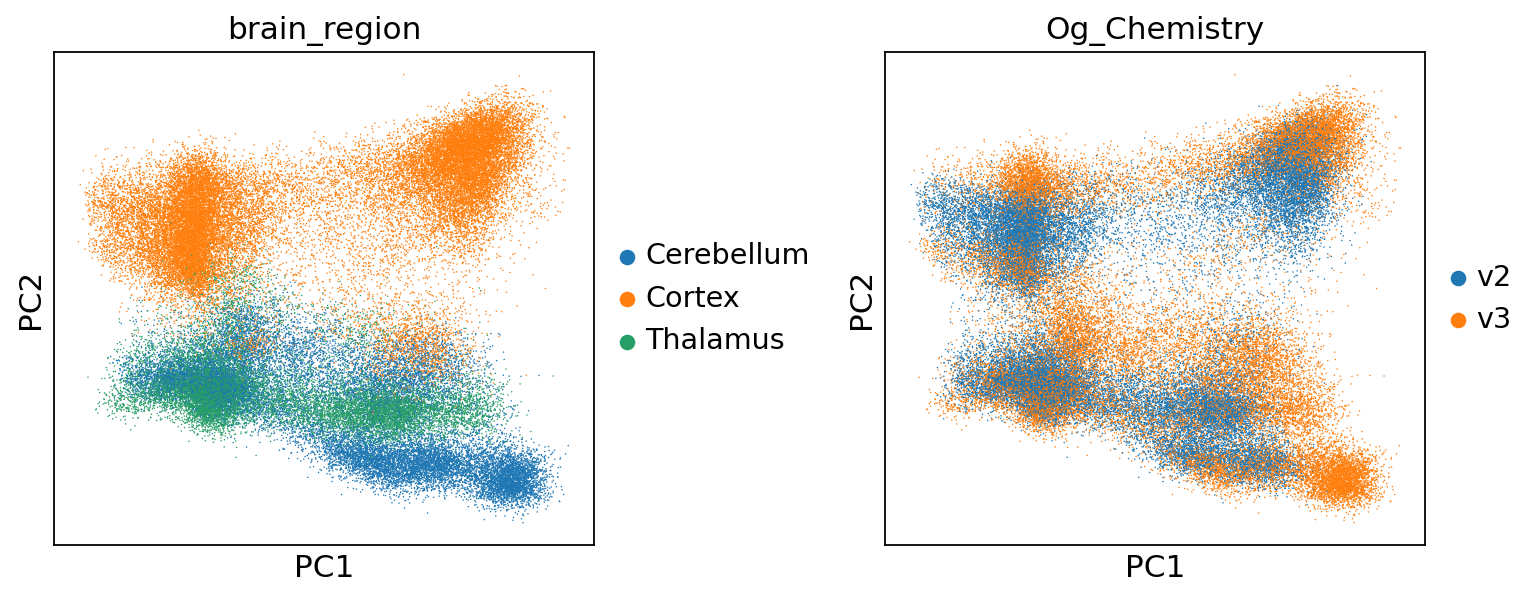

In [29]:

sc.pl.pca(adata, color=['brain_region', 'Og_Chemistry'], ncols=2, wspace=0.4) #specifying the meta column of interest

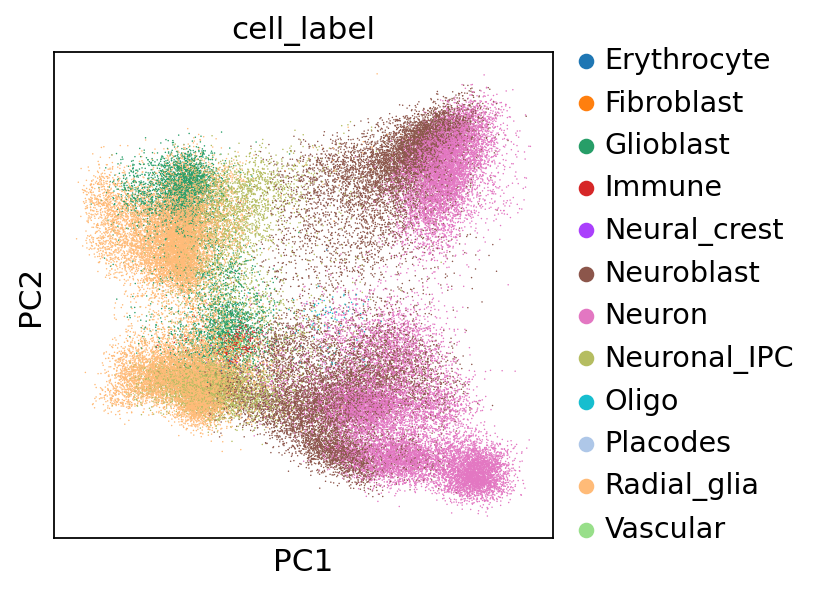

In [30]:
sc.pl.pca(adata, color=['cell_label'], ncols=1)

### ⚠️❓ *How many PC would you select for the calculation of neighbors?*

Specify your choice in the N_PCs variable

<details>

<summary>Hint</summary>

Check the plot below:

> sc.pl.pca_variance_ratio(adata, log=True) 

> N_PCs = ChosenValue

</details>

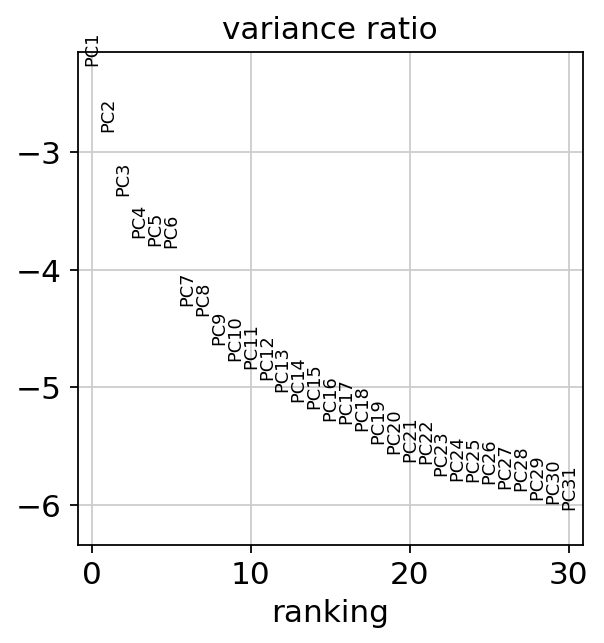

In [31]:
sc.pl.pca_variance_ratio(adata, log=True)
N_PCs = 15

## 6.2 Neighbours

[sc.pp.neighbors](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html) computes a neighborhood graph of observations. The cells are embedded in a graph structure with edges drawn between cells with similar feature expression patterns. A k-nearest neigbour graph will connect each cell with the its k-nearest neigbours.

__Key parameters:__ 
> * `n_pcs`: number of PC used for compute the kNN graph
> * `n_neighbors`: number of neighbors. Larger neighbor values will result in more global structure being preserved at the loss of detailed local structure. 
> * `metrics`: distance metric used in the calculation

In [32]:
N_NB = int(0.5 * len(adata) ** 0.5)
if N_NB > 80:
    N_NB = 80
print(N_NB) 

80


In [33]:
sc.pp.neighbors(adata, n_neighbors=N_NB, n_pcs=N_PCs, key_added="pca")

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['pca']`
    `.obsp['pca_distances']`, distances for each pair of neighbors
    `.obsp['pca_connectivities']`, weighted adjacency matrix (0:01:26)


### ⚠️❓ *How does the choice of neighbours impact on downstream steps? How changes the UMAP if you select a bigger/smaller number of neighbours?*

In an alternative workflow, try to increase / decrease the n_neighbors parameter and observe the impact on the resulting UMAP. 

## 6.3 UMAP



In [34]:
sc.tl.umap(adata, random_state=1, neighbors_key="pca")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:59)


### ⚠️❓ Which metadata are you curious to plot on the UMAP? 
### ⚠️❓ What information are you retrieving? 
### ⚠️❓ Are there indications of batch effects?

<details>

<summary>Hint</summary>

> adata.obsm["X_umap_nocorr"] = adata.obsm["X_umap"].copy() #to store UMAP coordinates in a new slot

> del adata.obsm["X_umap"]

> sc.pl.embedding(adata, basis="X_umap_nocorr", 
                color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'])

> sc.pl.embedding(adata, basis="X_umap_nocorr", 
                color=['MetaCols'])

</details>

In [35]:
sc.tl.umap(adata, random_state=1, neighbors_key="pca")
# store coordinates in a named slot so to avoid confusion with batch-corrected
adata.obsm["X_umap_nocorr"] = adata.obsm["X_umap"].copy()
del adata.obsm["X_umap"]

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


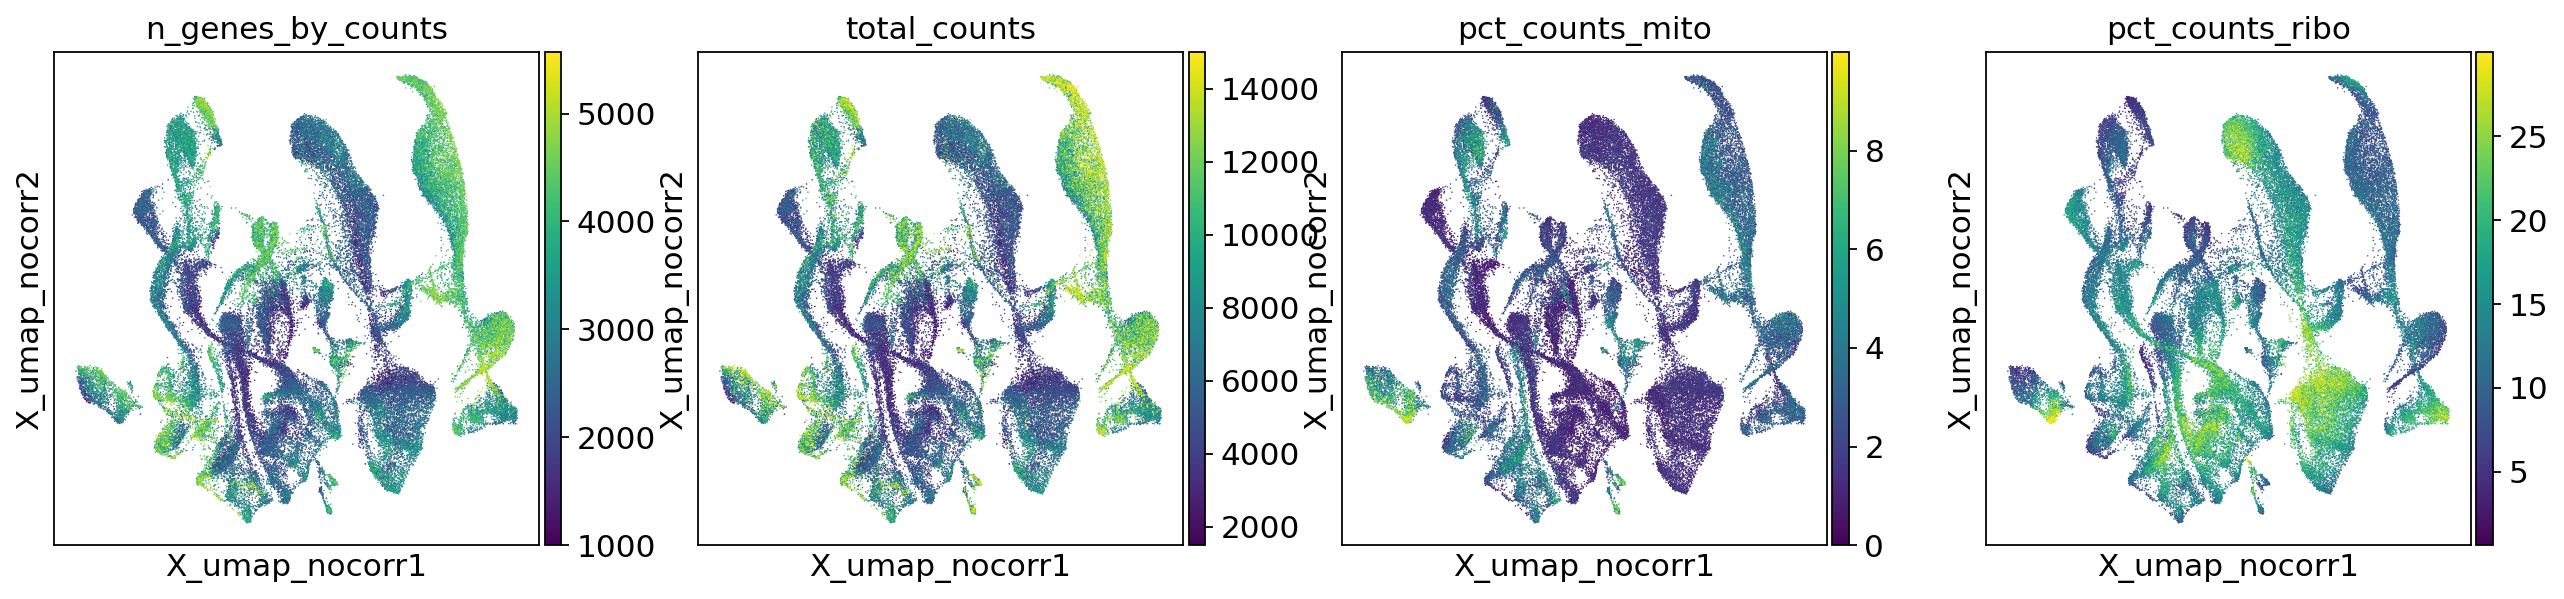

In [36]:
sc.pl.embedding(adata, basis="X_umap_nocorr", 
                color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'])

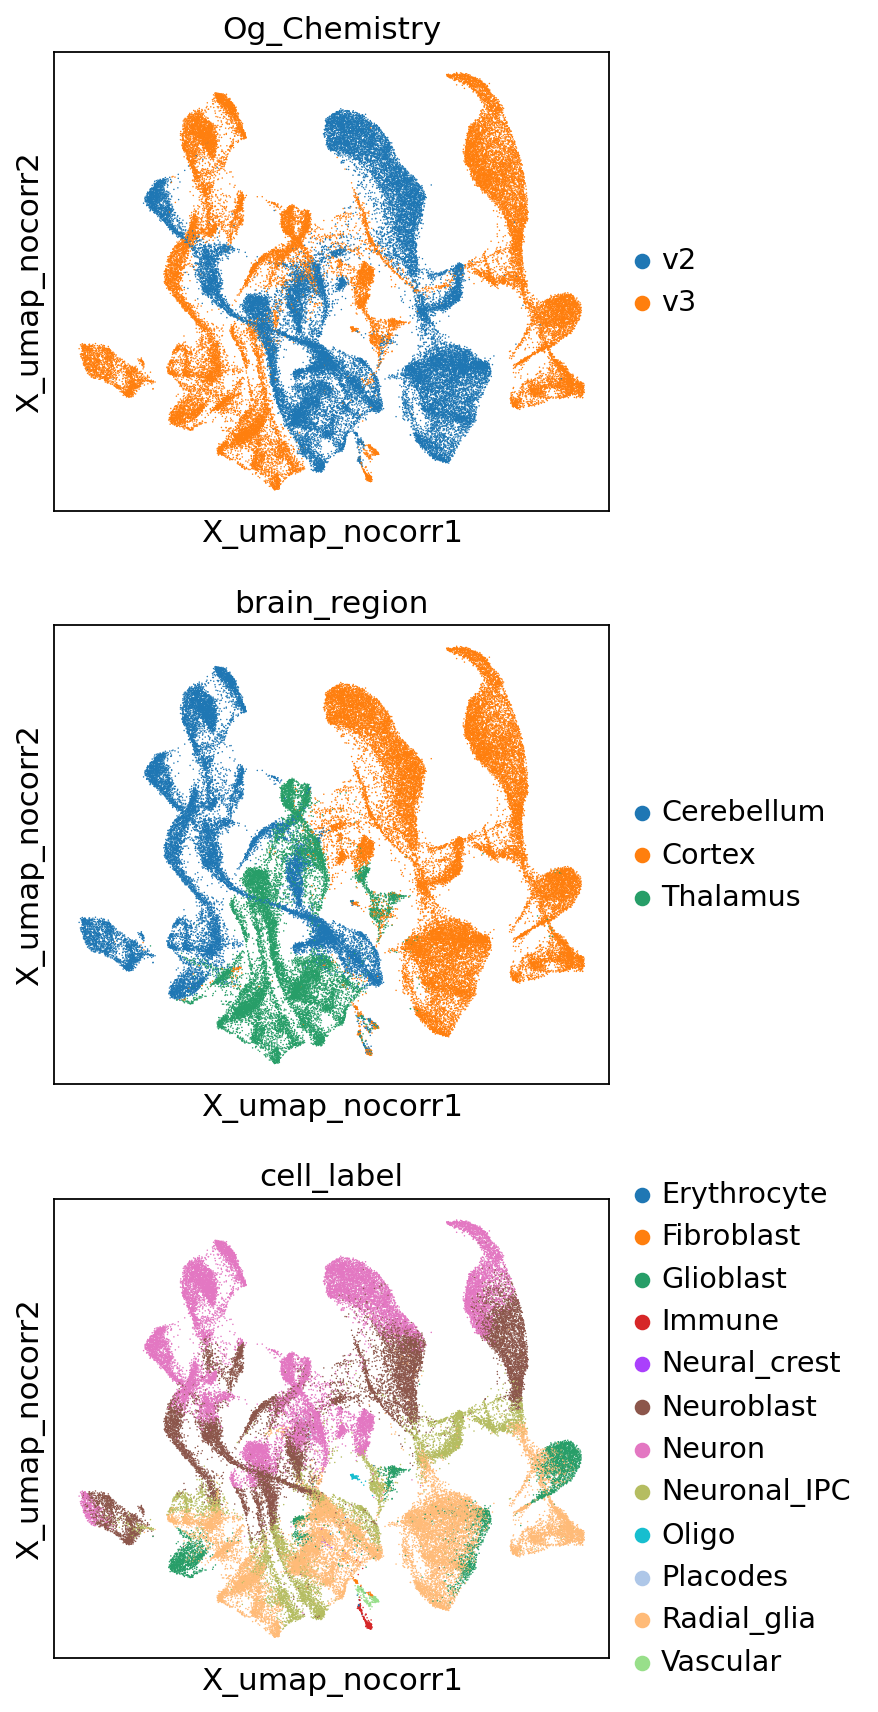

In [37]:
sc.pl.embedding(adata,  basis="X_umap_nocorr", color=['Og_Chemistry', 'brain_region', 'cell_label'], ncols=1)

-------------

# 7. Batch correction by Harmony

### ⚠️❓ Do you think the dataset is affected by a batch effect?

__If you think there is a potential batch effect, set the BATCH_KEY coordinate accordingly and then run the integration by Harmony__

In [38]:
#Write below
BATCH_KEY = 'Og_Chemistry'

In [39]:
sc.external.pp.harmony_integrate(adata, BATCH_KEY)

2024-11-05 15:31:19,865 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-05 15:31:25,901 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-05 15:31:26,094 - harmonypy - INFO - Iteration 1 of 10
2024-11-05 15:31:35,729 - harmonypy - INFO - Iteration 2 of 10
2024-11-05 15:31:45,167 - harmonypy - INFO - Iteration 3 of 10
2024-11-05 15:31:54,621 - harmonypy - INFO - Iteration 4 of 10
2024-11-05 15:32:03,417 - harmonypy - INFO - Iteration 5 of 10
2024-11-05 15:32:11,255 - harmonypy - INFO - Converged after 5 iterations


In [40]:
sc.pp.neighbors(adata, n_neighbors=N_NB, n_pcs=N_PCs, use_rep='X_pca_harmony', key_added='harmony')

computing neighbors
    finished: added to `.uns['harmony']`
    `.obsp['harmony_distances']`, distances for each pair of neighbors
    `.obsp['harmony_connectivities']`, weighted adjacency matrix (0:00:41)


-----------------------

# 8. Batch-corrected dimensionality reduction

You can now check the results of your strategy, plotting the integrated UMAP

In [41]:
sc.tl.umap(adata, random_state=1, neighbors_key="harmony")
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()
del adata.obsm["X_umap"]

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:59)


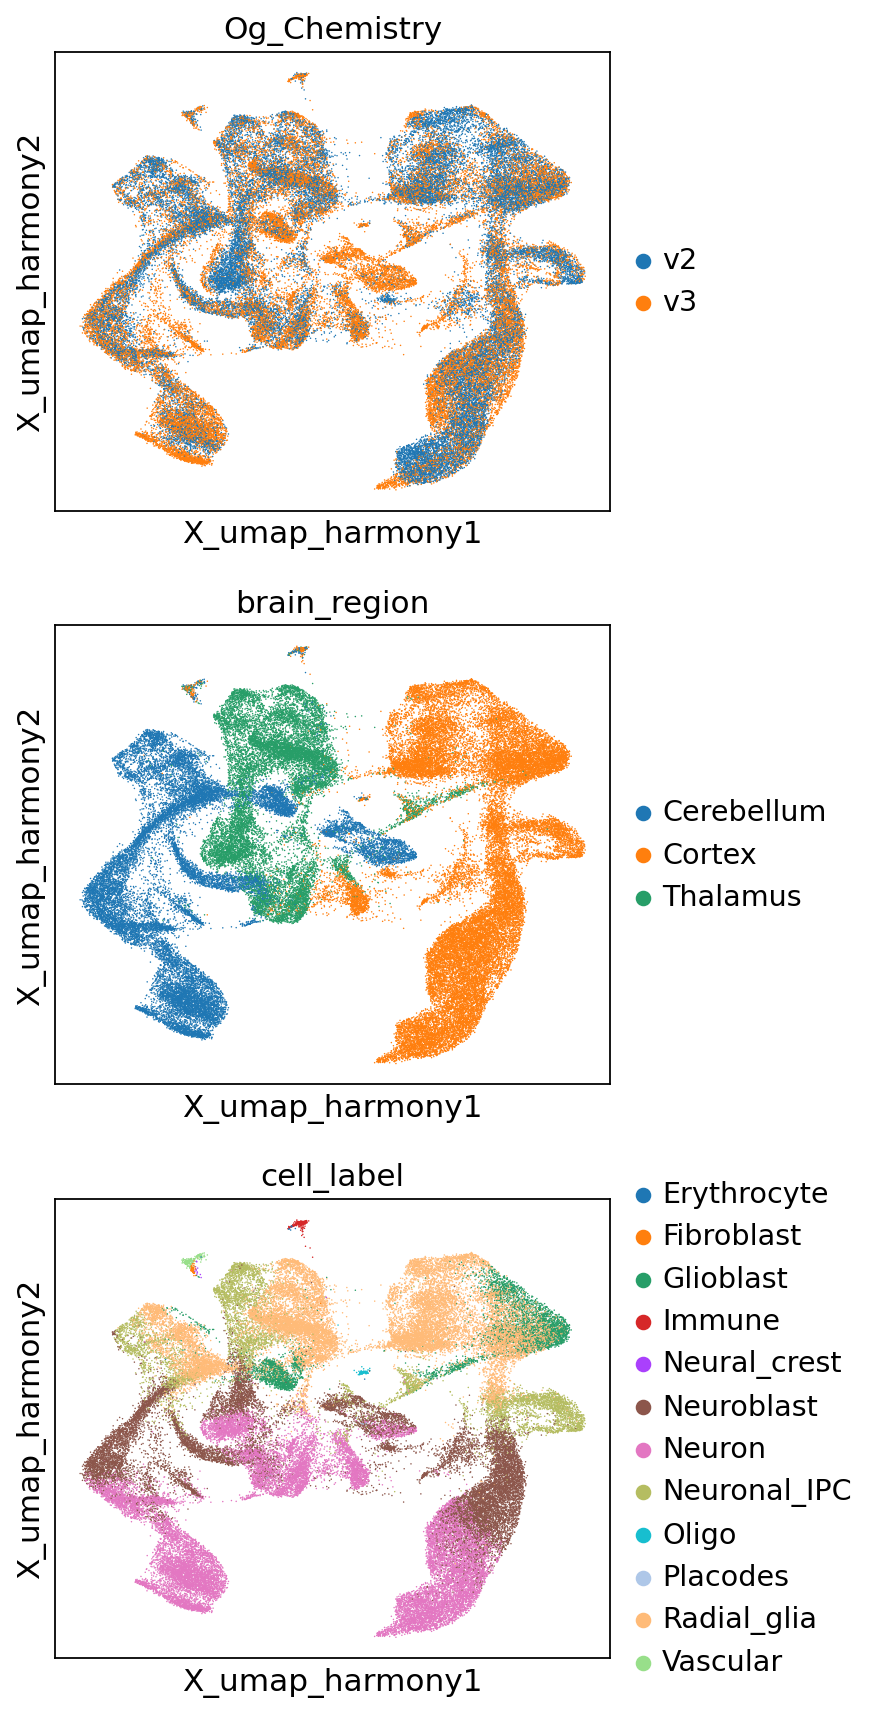

In [42]:
sc.pl.embedding(adata,  basis="X_umap_harmony", color=['Og_Chemistry', 'brain_region', 'cell_label'], ncols=1)

### ⚠️❓Which other dimensionality reduction approach could you apply? 


In [43]:
sc.tl.diffmap(adata, random_state=1, neighbors_key="harmony")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9990513  0.99869865 0.99745095 0.9956875  0.9939897
     0.9933842  0.9926461  0.99151915 0.9910157  0.98963326 0.9888466
     0.9877823  0.98728126 0.98529077]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:07)


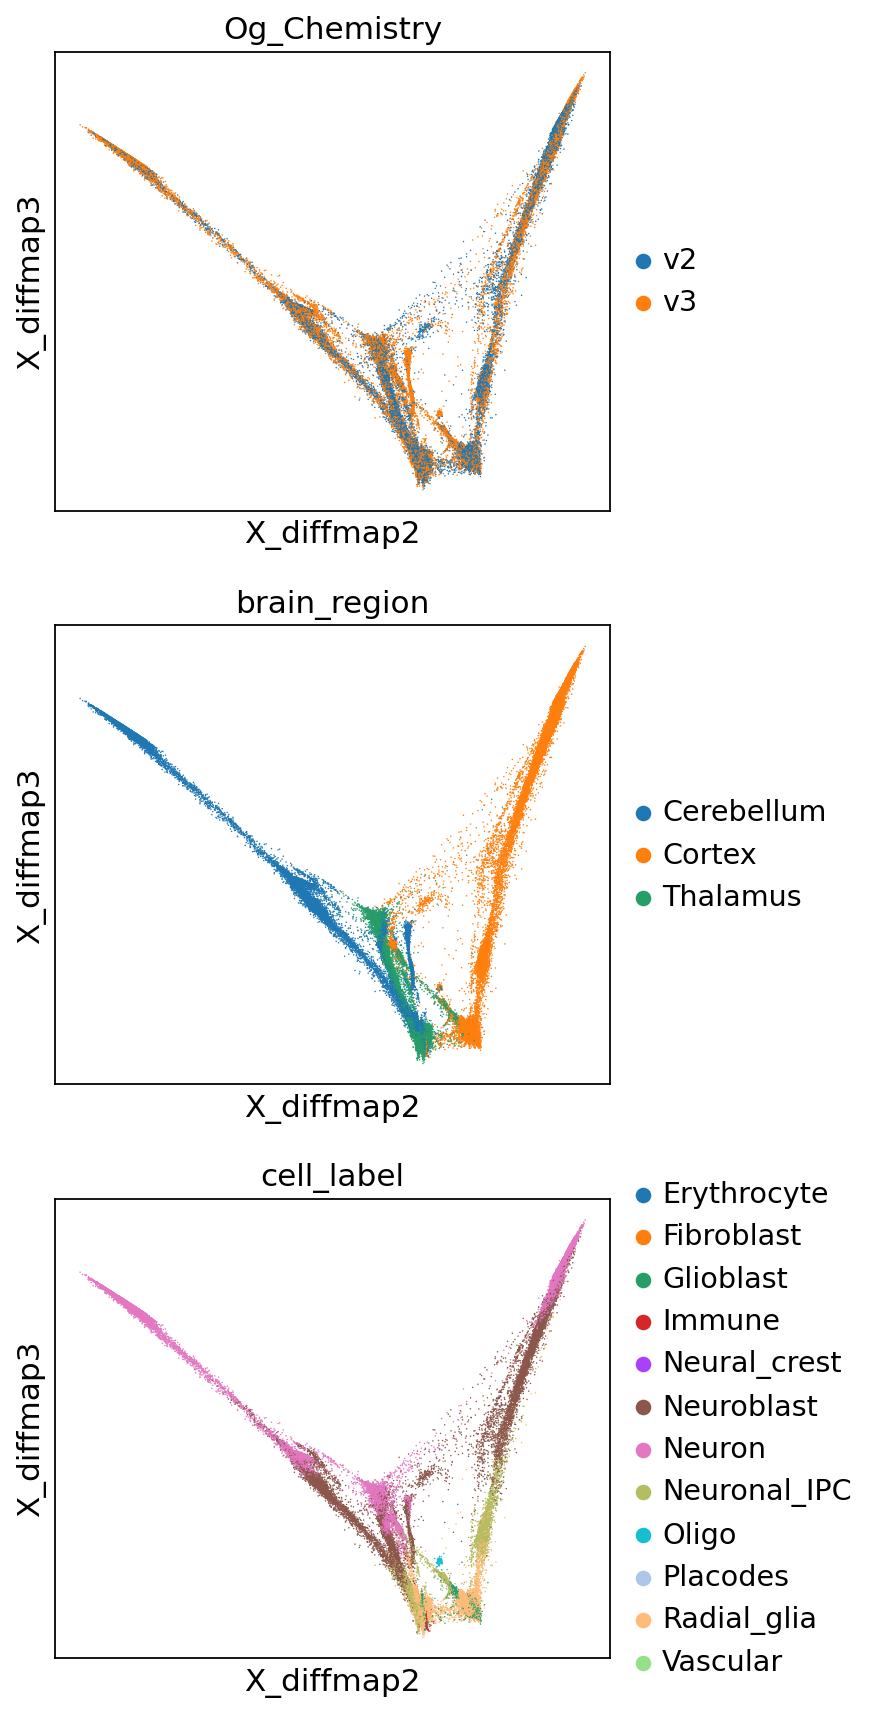

In [44]:
sc.pl.embedding(adata, basis="X_diffmap", components=['2,3'], color=['Og_Chemistry', 'brain_region', 'cell_label'], ncols=1)

-------


# 9. OPTIONAL SECTION: Cell type annotation

### ⚠️❓How would you proceed to have a first idea of the cell populations that have been profiled in the dataset? 

<details>

<summary>Hint</summary>


Identify clusters and then try several strategies to annotate them. 

Once you have get your own idea of annotation, you can compare with the metadata that are available in the obs slot.

</details>

-----

# 10. SAVE ANNDATA

Save your anndata so that it will be available for the second part of the project. 

In [ ]:
# write your code